<h1><center> <font color="red"> STAY SAFE !! </font> </center></h1>


<h1><center>HW4 Language Modeling (LM)</center></h1>
<h2><center>Due: April 2020 10th, 23:59</center></h2>

In this homework, you will first implement a simple bigram language model on a dataset containing news headlines, learn basic concepts of marcov modeling, words sampling, and perplexity. 

Then things start get very fun and open ended. You will be shown a simple word based RNN LM. Understand how it works, and then apply changes to it as you wish. Things you can try but not limited to:

1. Word based RNN model with subword embedding
2. Character based RNN model
2. Try different model architecture
3. Try different training corprus
4. Personalized LM

**You are given the following files**:
- `Language_Modeling.ipynb`: Notebook file with starter code
- `headlines.train`: Training set to train your model
- `headlines.dev`: Test set to report your model’s performance
- `glove_300d.csv`: Glove embedding truncated for the vocab in the training data
- `../utils/`: folder containing all utility code for the series of homeworks

**Deriverables**:
- pdf or html of the notebook
- A report of your own model if you have 

### ======================== Coding starts here ====================

# Setup

##  Load functions

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import os, sys, random
import pandas as pd
import numpy as np
from nltk.stem import WordNetLemmatizer
from nltk import word_tokenize

# add utils folder to path
p = os.path.dirname(os.getcwd())
if p not in sys.path:
    sys.path = [p] + sys.path

from utils.hw4 import (load_data, load_data_char, gen_vocab, START, END, UNK, 
                       load_embedding)
from utils.general import sigmoid, tanh, show_keras_model

Using TensorFlow backend.
/Library/Python/3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Library/Python/3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Library/Python/3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Library/Python/3.7/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 

## Load data 

In [2]:
# The input is trucated for fast iteration
# Remember to use the full set of data for your final model training
# It may take some time
headlines_train = load_data("headlines.train")
headlines_dev = load_data("headlines.dev")

# Before we begin, let's look at what some of the headlines look like. 
# Run the following code block as many times as you want to get a sense 
# of what kind of headlines we hope to generate.
for headline in random.sample(headlines_train, 5):
    print(START + ' '.join(headline) + END)

<START>police probe school break ins<END>
<START>prisoner escapes after posing as identical twin<END>
<START>majority of public servants satisfied report<END>
<START>latrobe valley residents protest over paper mill foreign workers<END>
<START>n korea says nuclear talks can resume if<END>


In [3]:
# Calculate the vocab list and the embedding 
# It (might) be helpful to remove low frequency words, so the model learns how to
# treat unseen vocabulary
vocab, re_vocab = gen_vocab(headlines_train, 4)
sent_len = max([len(s) for s in headlines_train]) + 1

print("Size of vocab: ", len(vocab))
print("Longest setence length: ", sent_len)

# Load the embedding, trick is played to fill the missing vocab
# you can look into the source file to see what it actually does
# This embedding file is truncated for vocab used in this dataset
# If you are to train your own model with your own data, remember to download
# the original embedding here: https://nlp.stanford.edu/projects/glove/
glove = load_embedding('glove_300d.csv', vocab=vocab)

glove.T.head()

Size of vocab:  19366
Longest setence length:  15


,<UNK>,<START>,<END>,to,in,for,of,on,over,the,...,doctoring,udia,aircon,kent,squalor,pilkadaris,jb,tc,troupe,hotham
0,-0.021299,-0.284755,0.140351,-0.248370,0.068507,-0.23909,-0.036429,0.000607,-0.089285,-0.208380,...,0.065363,0.784056,0.274826,-0.003250,0.082989,0.091578,0.093491,-0.204886,-0.358151,0.435992
1,-0.029468,0.306007,-0.072337,-0.454610,-0.023344,-0.64189,-0.285920,0.048631,-0.077838,-0.149320,...,0.058368,0.256304,0.261054,-0.023698,-0.029252,0.044466,0.592242,0.427977,-0.236637,-0.322775
2,-0.014882,-0.324568,-0.209596,0.039227,0.282710,-0.58322,0.063387,0.489690,-0.295420,-0.017528,...,-0.377588,-0.914117,-0.097649,-0.002529,0.097430,0.114199,-0.451862,-0.107156,0.221786,-0.356868
3,0.006492,0.038284,0.078233,-0.284220,-0.402150,-0.54743,-0.601220,0.427770,-0.335840,-0.028432,...,-0.148528,0.864144,-0.088590,0.028246,0.144958,-0.115276,0.547550,0.418092,-0.262851,0.492316
4,0.010641,0.130105,0.062671,-0.031852,0.077815,0.42386,-0.015309,-0.386100,0.287430,-0.060104,...,-0.380280,0.396062,0.270563,0.027954,-0.042216,-0.007769,0.375876,0.349217,0.290543,-0.495698


In [4]:
# Transform the DF to np array
glove = glove.values

## Util function

In [7]:
def to_label(token):
    """
    Simply transfer a token to its numerical label, if the token is not int
    the vocab, return the label of UNK
    input: 
        token: str
        
    output:
        int
    """
    return re_vocab.get(token, re_vocab[UNK])

def to_embedding(X):
    """
    For the 2 dimensional input X filled with the vocabulary label, 
    return an np.array of their embedding
    
    input:
        X: np.array(n_sample, sent_len)
        
    return:
        embdding
    """
    embedding = np.zeros((len(X), len(X[0]), glove.shape[1]))
    
    for i in range(len(X)):
        for j in range(len(X[0])):
            embedding[i,j,:] = glove[X[i][j]] 
    
    return embedding

def sample_with_weight(prob, avoid_UNK=True):
    """
    For a given probability distribution, return a random int sampled by the
    probability distribution. 
    
    input:
        prob: list of float probability
        avoid_UNK: boolean, if UNK should be excluded
    """
    unk_idx = re_vocab[UNK]
    
    if avoid_UNK: 
        prob[unk_idx] = 0 # Make sure we do not use UNK in the generated text
    
    # If the distribution is 0, use uniform distribution
    if prob.sum() <= 0:
        prob[1:] = 1.0
        
    return np.random.choice(range(len(prob)), p=prob/prob.sum())

# Tri-gram (second order) Markov Model

## Build FNN  Bi-Gram model

W0411 22:05:35.925065 4525321664 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0411 22:05:35.962076 4525321664 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0411 22:05:35.993237 4525321664 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_1 (Reshape)          (None, 600)               0         
_________________________________________________________________
Dense-1 (Dense)              (None, 100)               60100     
_________________________________________________________________
Dense-2 (Dense)              (None, 19366)             1955966   
Total params: 2,016,066
Trainable params: 2,016,066
Non-trainable params: 0
_________________________________________________________________


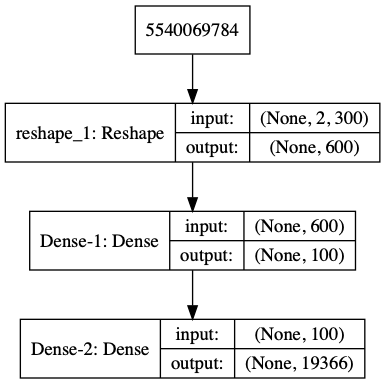

In [8]:
from keras.models import Sequential
from keras.layers import Dense, Reshape

n_gram = 2

# For simplicity, we use the embedding of words to feed the model, therefore
# no need to add a Embedding layer in the begining. But for a possibly better performance
# you can add a embedding layer, even better if you use the glove embedding matrix as the
# initial value for the embedding layer
# This is useful also because we have filled the embedding with random values for those missing
# vocabularies, allowing the embedding matrix to relax during training will improve the performance 
# for these words as well. But be prepared that this would slow down the training
FNN_model = Sequential()
FNN_model.add(Reshape(target_shape=(n_gram * glove.shape[1],), 
                      input_shape=(n_gram, glove.shape[1],)))
FNN_model.add(Dense(100, activation="relu", name="Dense-1"))
FNN_model.add(Dense(len(vocab), activation="softmax", name="Dense-2"))

FNN_model.summary()
show_keras_model(FNN_model)

## Training data generator

In [9]:
from keras.utils import to_categorical
import random

def gen_sample_FNN(data, batch_size=1000, one_hot=True):
    """
    For training the model, we need to shift the data by -1 to produce
    label, i.g.
    ["word1", "word2", "word3", "word4"] --> 
    X: [[START, STSRT],
        [START, 1],
        [1, 2],
        [2, 3],
        [3, 4]]
    Y: [1, 2, 3, 4, ...] if one_hot is False, the label is translated to 
        one-hot if ont_hot is True
    
    inputs:
        data: list of list of strings
        batch_size: int
        one_hot: boolean
        
    outputs:
        X: np.array(batch_size, n_gram, embedding_dim)
        Y: np.array(batch_size, ) or np.array(batch_size, vocab_size)
        
    batch size is used to control the size for each data batch
    set batch_size = -1 if you don't want to generate by batch
    """
    if batch_size == -1:
        batch_size = sum([len(s) + 1 for s in data])
        
    while True:
        # Use shuffle so the order in each epoch is different
        random.shuffle(data)

        X, Y = [], []
        for d in data:
            encodes = [re_vocab[START], re_vocab[START]] +\
                      [to_label(t) for t in d] +\
                      [re_vocab[END]]
            for i in range(len(encodes) - 2):
                X.append([encodes[i], encodes[i+1]])
                Y.append(encodes[i+2])

                if len(X) >= batch_size:
                    X = to_embedding(X)
                    Y = np.array(Y)
                    
                    if one_hot:
                        Y = to_categorical(Y, num_classes=len(re_vocab))
                        
                    yield X, Y
                    X, Y = [], []

## Generate text

In [10]:
def generate_text_FNN(model, max_len=sent_len-1, seed=None):
    """
    For a given FNN model, generate text. If seed is not provided,
    use START as initial seed.
    
    inputs:
        model: FNN model
        max_len: int, maximum length of the setence
        seed: str, the seed word used to generate the text
    """
    
    result = []
    prev = START
    if not seed:
        seed = START # <START> <START>  // <START> seed
    result.append(seed)
    next_word = None
    while len(result) < max_len and next_word != END:
        input_X = [[to_label(prev),to_label(seed)]]
        input_X = to_embedding(input_X)
        prob = model.predict(input_X).flatten()
        sample = sample_with_weight(prob)
        next_word = vocab[sample]
        result.append(next_word)
        prev, seed = seed, next_word
    
    """
    hints:
    1. It's a trigram model, what your intial seed look like?
    2. The prediction of each state should return a list of probability, use the 
       `sample_with_weight` function to help you sample the next word.
    3. When the word END is sampled, you need to stop the setence. Also use the max_len
       to force ending the setence to avoid the program running forever.
    """
        
    return ' '.join(result)

In [11]:
# Before we train the model, let first check if the text generation function
# works as expected. Don't worry if the sentence doesn't make any sense.
# We haven't trained the model yet!
generate_text_FNN(FNN_model, seed="china")

W0411 22:05:41.307667 4525321664 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:2741: The name tf.Session is deprecated. Please use tf.compat.v1.Session instead.

W0411 22:05:41.310365 4525321664 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.



'china ipcc bella distribution refutes institution caleb von shotgun wasting masterchef accounting rather dealings'

## Calculate Perplexity

In [12]:
def calculate_perplexity_FNN(model, X, y):
    """
    For a given FNN model, and test data, calcualte the perplexity.
    The definition of perplexity is:
    
    perplexity = exp(- \sum_i log(P_i) / N)
    
    inputs:
        model: FNN model
        X: np.array(n_sample, n_gram, embedding_dim)
        y: np.array(n_sample), int label of the next word    
    """
    
    prob = model.predict(X)
    P = 0.
    N = len(y)
    for s in range(N):
        P += np.log(prob[s,y[s]])
    
    perplexity = np.exp(-P/N)
    
    """
    
    hits:
        1. First make the prod prediction using the model
        2. The probability at the position of y is what you look for
    
    When you have too much UNK word, you will find the perplexity to be lower, but it doesn't 
    really mean your model is better, can you think why?
    """

    return perplexity

 When we have too much UNK word in the dev set, that means the dev set has many words that is not in the training set vocabulary, When y_i is UNKNOWN P_i would be large, then perplexity is small. The preplexity only reflects the goodness of prediction when most of the words are using the save vocab and does not have many UNKNOWNS.
 
if the model predict a lot of UNK words. he UNK word will process a very high probabality while the other tokens have lower probablities. The labels are meaningful words so the P_i will be a very small positive number, then the perplexity is also going to be unreasonable small.
 
 if the model just predict random probablitities, then:
 
 $p_i ～= \frac{1}{vocab\_size}$
 
 $\sum_i log(P_i) / N = - N * \frac{log(vocab\_size)}{N} = - log(vocab\_size)$
 
 $perplexity = exp(- \sum_i log(P_i) / N) = vocab\_size$

In [13]:
# Let check the perplexity for the untrained model
# Is your value close to the number of vocabulary? 
# Is this a coincidence?
X_dev_FNN, y_dev_FNN = next(gen_sample_FNN(headlines_dev, batch_size=-1, one_hot=False))

calculate_perplexity_FNN(FNN_model, X_dev_FNN, y_dev_FNN)

19379.232239654484

## Training the model

In [14]:
"""
Let's use the function defined above to report the model performance
after each epoch
"""
def on_epoch_end_FNN(epoch, logs):
    print('----- Generating text after Epoch: %d' % epoch)
    for i in range(3):
        print(generate_text_FNN(FNN_model))
    print('Current perplexity on dev data: ', 
          calculate_perplexity_FNN(FNN_model, X_dev_FNN, y_dev_FNN), '\n')

In [15]:
from keras.callbacks import LambdaCallback

"""
Notice how the metrics / generated text evolve after each epoch
"""
FNN_model.compile(loss='categorical_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy', 'top_k_categorical_accuracy'])

batch_size = 512
steps_per_epoch = sum([len(s) + 1 for s in headlines_train]) // batch_size + 1
FNN_model.fit_generator(gen_sample_FNN(headlines_train, batch_size=batch_size), 
                        epochs = 10, steps_per_epoch=steps_per_epoch,
                        callbacks=[LambdaCallback(on_epoch_end=on_epoch_end_FNN)])

W0411 22:06:00.654759 4525321664 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/site-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0411 22:06:00.847187 4525321664 deprecation.py:323] From /usr/local/lib/python3.6/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/10
  39/2892 [..............................] - ETA: 13:21 - loss: 8.9232 - acc: 0.1096 - top_k_categorical_accuracy: 0.1897

KeyboardInterrupt: 

# Word-based RNN Language Model

## Build LSTM model

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 15, 128)           219648    
_________________________________________________________________
time_distributed_1 (TimeDist (None, 15, 19366)         2498214   
Total params: 2,717,862
Trainable params: 2,717,862
Non-trainable params: 0
_________________________________________________________________


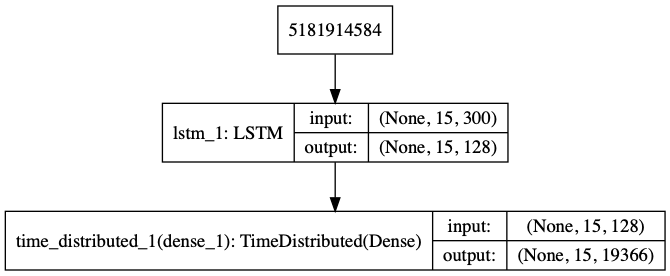

In [16]:
from keras.layers import Dense, LSTM, Activation, TimeDistributed

# For simplicity, we use the embedding of words to feed the model, therefore
# no need to add a Embedding layer in the begining. But for a possibly better performance
# you can add a embedding layer, even better if you use the glove embedding matrix as the
# initial value for the embedding layer
# This is useful also because we have filled the embedding with random values for those missing
# vocabularies, allowing the embedding matrix to relax during training will improve the performance 
# for these words as well. But be prepared that this would slow down the training

# Unfortunately Keras does not have an easy way to support dynamic length of input for RNN model.
# So we use the sent_len to truncate all the sentences.
batch_size = 10
RNN_train_model = Sequential()
RNN_train_model.add(
    LSTM(128, input_shape=(sent_len, glove.shape[1]), return_sequences=True)
    )
RNN_train_model.add(TimeDistributed(Dense(len(vocab), activation='softmax')))
RNN_train_model.summary()
show_keras_model(RNN_train_model)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (1, 1, 128)               219648    
_________________________________________________________________
time_distributed_2 (TimeDist (1, 1, 19366)             2498214   
Total params: 2,717,862
Trainable params: 2,717,862
Non-trainable params: 0
_________________________________________________________________


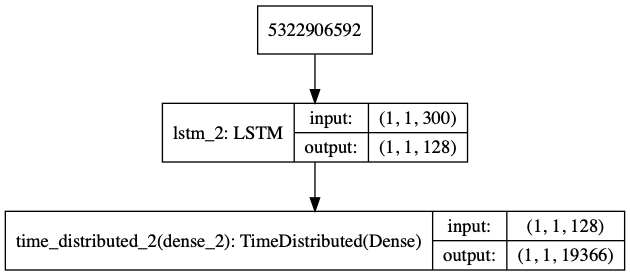

In [17]:
from keras.layers import Dense, LSTM, Activation, TimeDistributed

"""
# It's tricky to explain why we need the RNN_pred_model. 
# The RNN_train_model.predict requires a fix length of input (sent_len in our case).
# This is not convenient for us because we need to generate the next text one by one.
# The trick we play here is to create a shadow model having only 1 time step. We will
# copy the parameter of the RNN_train_model to this model once it's trained.
# Check generate_text_RNN function to understand details, and there is some discussion 
# here: "https://github.com/keras-team/keras/issues/8771"
"""

RNN_pred_model = Sequential()
RNN_pred_model.add(
    LSTM(128, batch_input_shape=(1, 1, glove.shape[1]), return_sequences=True, stateful = True)
    )
RNN_pred_model.add(TimeDistributed(Dense(len(vocab), activation='softmax')))
RNN_pred_model.summary()
show_keras_model(RNN_pred_model)

## Training data generator

In [18]:
from keras.preprocessing.sequence import pad_sequences

def gen_sample_RNN(data, batch_size=100, one_hot=True):
    """
    The input is the same to the FNN model, but the output training data is different.
    
    inputs:
        data: list of list of string
        batch_size: int
        one_hot: boolean
        
    output:
        X: np.array(batch_size, sent_len, embedding_dim)
        Y: np.array(batch_size, sent_len, ) or np.array(batch_size, sent_len, vocab_size)
    """
    if batch_size == -1:
        batch_size = len(data)
        
    while True:
        # Shuffle the data so data order is different for different epochs
        random.shuffle(data)

        X, Y = [], []
        for s in data:
            X.append([to_label(START)] + [to_label(t) for t in s])
            Y.append([to_label(t) for t in s] + [to_label(END)])
            
            if len(X) >= batch_size:   
                X = pad_sequences(sequences=X, maxlen=sent_len, padding='post', value=to_label(END))
                Y = pad_sequences(sequences=Y, maxlen=sent_len, padding='post', value=to_label(END))
          
                if one_hot: Y = to_categorical(Y, num_classes=len(re_vocab))
                
                yield to_embedding(X), Y
                
                X, Y = [], []

## Generate text

In [19]:
def generate_text_RNN(model, max_len=sent_len-1, seed=None):
    """
    Use the RNN_pred_model to generate text. Notice how we use the stateful model to generate
    the next word one by one. Make sure you fully understand each line of this code. 
    """
    if seed is None:
        seed = START
        result = []
    else:
        result = [seed]
    
    model.reset_states()
    
    for i in range(max_len):
        X = to_embedding([[to_label(seed)]])
        idx = sample_with_weight(model.predict(X)[0][0])
        
        if vocab[idx] == END: break
            
        seed = vocab[idx]
        result.append(seed)
        
    return ' '.join(result)

In [20]:
generate_text_RNN(RNN_pred_model, seed="china")

'china madoff nasty dividend immune playboy supercomputer monaro battens davydenko outer resourced rev shower who'

## Calculate Perplexity

In [21]:
def calculate_perplexity_RNN(model, X, y):
    """
    For a given FNN model, and test data, calcualte the perplexity.
    The definition of perplexity is:
    
    perplexity = exp(- \sum_i log(P_i) / N)
    
    inputs:
        model: FNN model
        X: np.array(n_sample, sent_len, embedding_dim)
        y: np.array(n_sample, sent_len), int labels
    """
    prob = model.predict(X)
    M = 0
    P = 0
    N, sent_len = y.shape
    for s in range(N):
        for l in range(sent_len):
            if y[s,l] == re_vocab[END]:
                break
            P += np.log(prob[s,l,y[s,l]])
            M += 1
    
    perplexity = np.exp(-P/M)
    """
    
    hits:
        1. First make the prod prediction using the RNN_train_model
        2. The probability at the position of y is what you look for
        3. All sentences have fixed length, meaning a sentence can have multiple padding END at the end
           of a sentence. Consider stop counting the perplexity once you hit the first END, otherwise
           your perplexity will seem too good.
    
    When you have too much UNK word, you will find the perplexity to be lower, but it doesn't 
    really mean your model is better, can you think why?
    """
    
    return perplexity

In [22]:
# Let check the perplexity for the untrained model
# Is your value close to the number of vocabulary? 
# Is this a coincidence?
X_dev_RNN, y_dev_RNN = next(gen_sample_RNN(headlines_dev, batch_size=-1, one_hot=False))

calculate_perplexity_RNN(RNN_train_model, X_dev_RNN, y_dev_RNN)

19389.0952061517

## Train model

In [23]:
"""
Let's use the function defined above to report the model performance
after each epoch
"""
def on_epoch_end_RNN(epoch, logs):
    RNN_pred_model.set_weights(RNN_train_model.get_weights())
    print('----- Generating text after Epoch: %d' % epoch)
    for i in range(3):
        print(generate_text_RNN(RNN_pred_model))
    print('Current perplexity on dev data: ', 
          calculate_perplexity_RNN(RNN_train_model, X_dev_RNN, y_dev_RNN), '\n')

In [24]:
"""
Notice how the metrics / generated text evolve after each epoch
"""
batch_size = 10
num_batches = len(headlines_train) // batch_size 
RNN_train_model.compile(loss='categorical_crossentropy', optimizer='adam')
RNN_train_model.fit_generator(gen_sample_RNN(headlines_train, batch_size), num_batches, 10,
          callbacks=[LambdaCallback(on_epoch_end=on_epoch_end_RNN)])

Epoch 1/10
20000/20000 [==============================] - 2069s 103ms/step - loss: 3.1110
----- Generating text after Epoch: 0
fairfax pulls aim to 100 million from f
adams west farmers association council questions
q history peninsula for historic
Current perplexity on dev data:  839.0277186026706 

Epoch 2/10
20000/20000 [==============================] - 2270s 114ms/step - loss: 2.8319
----- Generating text after Epoch: 1
hospital patients held to save survey
abc sport
cricket x palau mottram to custody over game ticket medal
Current perplexity on dev data:  727.8745405344695 

Epoch 3/10
20000/20000 [==============================] - 2911s 146ms/step - loss: 2.7508
----- Generating text after Epoch: 2
rolf harris named worlds most british mcdonalds show
suspects return home may wounds
philip devastated by wall street
Current perplexity on dev data:  725.0630279119446 

Epoch 4/10
20000/20000 [==============================] - 3231s 162ms/step - loss: 2.7050
----- Generating text af